<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/Penggabungan_GAT_dan_GPT_2_kecil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

!pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
dataset_name = 'CiteSeer'
dataset = Planetoid(root='data/CiteSeer', name=dataset_name)

data = dataset[0]

Processing...
Done!


In [4]:
print("===== INFORMASI DATASET =====")
print(f"Nama Dataset      : {dataset_name}")
print(f"Jumlah Graph      : {len(dataset)}")
print(f"Jumlah Fitur      : {dataset.num_features}")
print(f"Jumlah Kelas      : {dataset.num_classes}")
print(f"Jumlah Node       : {data.num_nodes}")
print(f"Jumlah Edge       : {data.num_edges}")
print(f"Average Node Degree : {data.num_edges / data.num_nodes:.2f}")
print(f"Jumlah Training Nodes : {data.train_mask.sum().item()}")
print(f"Jumlah Validation Nodes : {data.val_mask.sum().item()}")
print(f"Jumlah Test Nodes : {data.test_mask.sum().item()}\n")

===== INFORMASI DATASET =====
Nama Dataset      : CiteSeer
Jumlah Graph      : 1
Jumlah Fitur      : 3703
Jumlah Kelas      : 6
Jumlah Node       : 3327
Jumlah Edge       : 9104
Average Node Degree : 2.74
Jumlah Training Nodes : 120
Jumlah Validation Nodes : 500
Jumlah Test Nodes : 1000



In [5]:
labels = data.y
unique_labels, counts_labels = torch.unique(labels, return_counts=True)
print("\n=== DISTRIBUSI KELAS ===")
for lab, count in zip(unique_labels, counts_labels):
    print(f"Kelas {lab.item()}: {count.item()} node")

print("\n=== EDGE SAMPLE ===")
print(data.edge_index[:, :10])


=== DISTRIBUSI KELAS ===
Kelas 0: 264 node
Kelas 1: 590 node
Kelas 2: 668 node
Kelas 3: 701 node
Kelas 4: 596 node
Kelas 5: 508 node

=== EDGE SAMPLE ===
tensor([[ 628,  158,  486, 1097, 2919, 2933, 3285, 1431, 3219,  467],
        [   0,    1,    1,    1,    1,    1,    2,    3,    3,    4]])


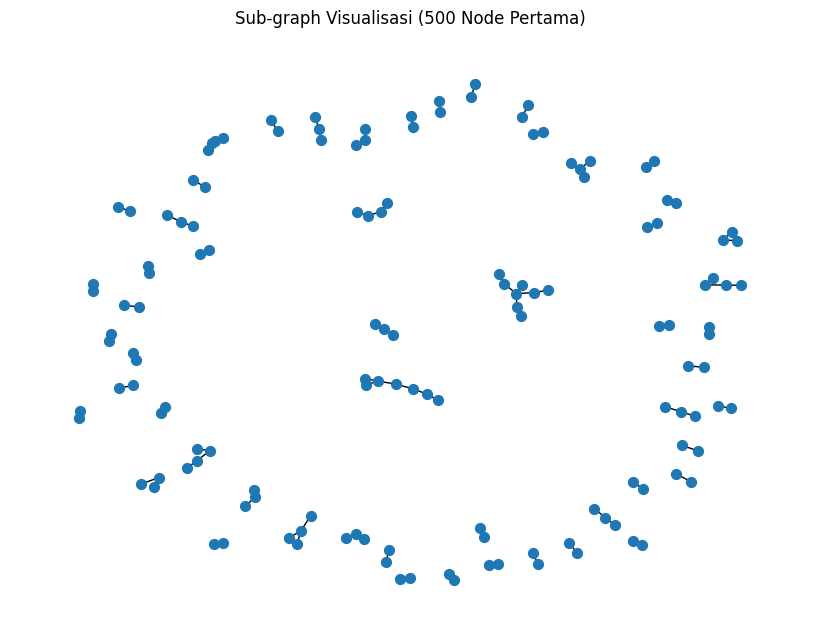

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

sub_node_count = 500
sub_edge_mask = (data.edge_index[0] < sub_node_count) & (data.edge_index[1] < sub_node_count)
sub_edge_index = data.edge_index[:, sub_edge_mask]

sub_G = nx.Graph()
sub_edges = list(zip(sub_edge_index[0].tolist(), sub_edge_index[1].tolist()))
sub_G.add_edges_from(sub_edges)

plt.figure(figsize=(8, 6))
nx.draw(sub_G, node_size=50)
plt.title("Sub-graph Visualisasi (500 Node Pertama)")
plt.show()

**DEFINISI MODEL GNN**

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Lapisan pertama
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5)

        # Lapisan kedua
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

**TRAINING & EVALUATION**

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)

    accs = []
    for mask_name, mask in zip(["Train", "Validation", "Test"],
                               [data.train_mask, data.val_mask, data.test_mask]):
        correct = preds[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs  # [train_acc, val_acc, test_acc]

In [11]:
print("===== PROSES TRAINING GCN =====")
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        train_acc, val_acc, test_acc = test()
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final Accuracy
train_acc, val_acc, test_acc = test()
print("\n===== HASIL AKHIR =====")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Val Accuracy   : {val_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}\n")

===== PROSES TRAINING GCN =====
Epoch: 020, Loss: 0.0037, Train Acc: 1.0000, Val Acc: 0.6780, Test Acc: 0.6830
Epoch: 040, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.6980, Test Acc: 0.6950
Epoch: 060, Loss: 0.0098, Train Acc: 1.0000, Val Acc: 0.6800, Test Acc: 0.6780
Epoch: 080, Loss: 0.0131, Train Acc: 1.0000, Val Acc: 0.6980, Test Acc: 0.6890
Epoch: 100, Loss: 0.0098, Train Acc: 1.0000, Val Acc: 0.6820, Test Acc: 0.6760
Epoch: 120, Loss: 0.0093, Train Acc: 1.0000, Val Acc: 0.6900, Test Acc: 0.6880
Epoch: 140, Loss: 0.0182, Train Acc: 1.0000, Val Acc: 0.6760, Test Acc: 0.6850
Epoch: 160, Loss: 0.0118, Train Acc: 1.0000, Val Acc: 0.6760, Test Acc: 0.6850
Epoch: 180, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.6800, Test Acc: 0.6720
Epoch: 200, Loss: 0.0119, Train Acc: 1.0000, Val Acc: 0.6940, Test Acc: 0.6810

===== HASIL AKHIR =====
Train Accuracy : 1.0000
Val Accuracy   : 0.6940
Test Accuracy  : 0.6810



**INTEGRASI LLM (HASIL)**

In [20]:
model_name = "gpt2"  # Model GPT-2 kecil
tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt2_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

def generate_summary(train_acc, val_acc, test_acc):
    prompt_text = (
        f"Saya baru saja melatih model Graph Neural Network (GCN) "
        f"pada dataset CiteSeer yang memiliki lebih dari 3000 node. "
        f"Berikut beberapa hasil evaluasi:\n"
        f"- Akurasi data latih: {train_acc:.2f}\n"
        f"- Akurasi data validasi: {val_acc:.2f}\n"
        f"- Akurasi data uji: {test_acc:.2f}\n\n"
        f"Ringkaskan hasil tersebut secara singkat:"
    )

    inputs = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    summary_ids = gpt2_model.generate(
        inputs,
        max_new_tokens=150, # Ubah ini kalo mau nambah jumlah output kata
        num_beams=2,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [21]:
summary_result = generate_summary(train_acc, val_acc, test_acc)
print("===== RINGKASAN LLM (GPT2) =====")
print(summary_result)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== RINGKASAN LLM (GPT2) =====
Saya baru saja melatih model Graph Neural Network (GCN) pada dataset CiteSeer yang memiliki lebih dari 3000 node. Berikut beberapa hasil evaluasi:
- Akurasi data latih: 1.00
- Akurasi data validasi: 0.69
- Akurasi data uji: 0.68

Ringkaskan hasil tersebut secara singkat:


The first two lines of the graph are the same as the first one, but the second one is a bit different. The first line shows the number of nodes in the network, and the last one shows how many nodes have been added to it.
. . .
"The network is very small, so it is not possible to get a good estimate of its size."
This is because there are only a few nodes that are in a network. This means that there is no way to estimate the size of each node, which is why it takes a lot of time to add nodes to the data. In order to do this, you need to know how much time it took for the node to be added. For example,
